7484       0
8104       0
8100       0
20682      0
2567       0
        ... 
16293    218
11868    218
16296    218
16283    218
16602    218
Length: 22077, dtype: int64

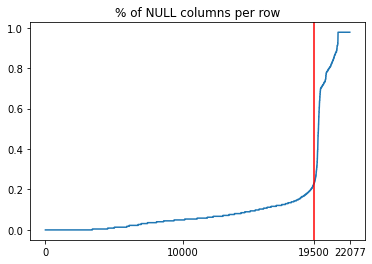

In [8]:
nulls_per_row = total.isnull().sum(axis=1).sort_values()
plt.plot(nulls_per_row.to_numpy() / len(total.columns))
plt.axvline(19500, color='red')
plt.xticks([0,10000,19500,len(total)])
plt.title('% of NULL columns per row')
nulls_per_row

In [15]:
# drop rows (ordered by n. of NULL values) from 19500 onward
to_drop = len(total) - 19500
df = total.drop(nulls_per_row.tail(to_drop).index)

## Normalize and delete redundant columns

# excluded columns are all non-float columns + PRICE VAR [%] column
# the rest are "num_cols": we work on these
excluded_cols = ['Stock', 'Sector', 'Class', 'Year', 'PRICE VAR [%]']
num_cols = [c for c in df.columns if c not in excluded_cols]
num_df = df[num_cols]

# Create correlation matrix
corr_matrix = num_df.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Drop columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df = df.drop(to_drop, axis=1)
num_df = num_df.drop(to_drop, axis=1)

imp_mean = IterativeImputer(random_state=0,max_iter=20)

left_bound = 0
left_size = 20
right_size = 20
cols = num_df.columns.tolist()

#Reorder columns
for left_bound in range (0,len(cols)-right_size-left_size+1,right_size+left_size):
    cols = cols[left_bound:left_bound+left_size] + cols[:left_bound] + cols[left_bound+left_size:]
    cols = cols[-right_size:] + cols[:-right_size]

#Fills the nulls within a integer-only matrix
table_only_integers = num_df[cols].to_numpy()
for i in range(0, len(cols)-left_size-right_size, left_size+right_size):
    subtable = table_only_integers[:,i:i+left_size+right_size]
    subtable = imp_mean.fit_transform(subtable)
    table_only_integers[:,i:i+left_size+right_size] = subtable
    print(f"Imputing is completed up to {i+left_size+right_size-1}th column")
subtable = table_only_integers[:,-left_size-right_size:]
subtable = imp_mean.fit_transform(subtable)
print("Imputing is completed up to last column")
table_only_integers[:,-left_size-right_size:] = subtable

#Replace with filled nulls
for i,col in enumerate(num_df.columns):
    df[col] = table_only_integers[:,i]
    df[col] = table_only_integers[:,i]

# Normalization
num_cols = [c for c in df.columns if c not in excluded_cols]
num_df = df[num_cols]
num_df = (num_df-num_df.mean())/num_df.std()
for col in num_df.columns:
    df[col] = num_df[col]

Imputing is completed up to 39th column
Imputing is completed up to 79th column
Imputing is completed up to 119th column
Imputing is completed up to last column


In [16]:
df.to_csv('./data/Financial_Data.csv',index=False)

In [17]:
print('Deleted columns with correlation higher than 0.9:',len(to_drop))

Deleted columns with correlation higher than 0.9: 84


Text(0.5, 1.0, ' of NULL rows per column')

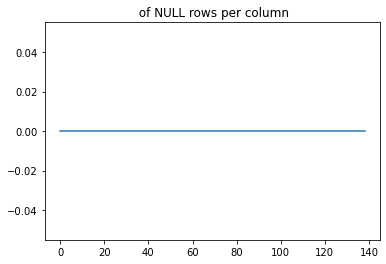

In [18]:
nulls_per_col = df.isnull().sum(axis=0).sort_values()
plt.plot(nulls_per_col.to_numpy() / len(df))
plt.title(' of NULL rows per column')